# Cross-selling car insurance 

## <u>Problem</u>
This project uses machine learning to predict whether a current health insurance customer will buy car insurance or not. The data was provided [on Kaggle](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction), and the goal is to maximise profit by:
* correctly identifying as many buyers as possible,
* while also correctly identifying as many non-buyers as possible. 

## <u>Solution</u>
### Summary
The best classifier proposed here correctly identifies X buyers out of 100 and X non-buyers of 100.

### Data
A labelled dataset collected about previous sales was used. Apart from the label (buyer or non-buyer), it also contains the following information:
* Demographics (gender, age, region)
* Car insurance coverage (previously insured or not, previous damage, monthly premium offered)
* Health insurance coverage (vintage, sales channel)

A training and test set were provided, but since this is a Kaggle challenge, the labels of the test set were not yet available. To evaluate the performance of the final model after hyperparameter tuning, a separate validation set was created from the training set. 

### Approach
Trained a variety of classifiers using default parameters, and evaluated their performace using 5-fold cross validation. If a classifier seemed promissing, I moved on to hyperparameter tuning via a grid search with 5-fold cross validation. The three best unrelated models were stacked to generate a voting classifier. Finally, the three best classifiers and the voting classifier were evaluated on the validation set. The best performing model was used to generate predictions on the test set.

* Scoring was performed using ROC AUC. The rationale behind this choice is [explained below](#Defining-metrics).<br><br>
* Classifiers tested:
    * Logsitic regression (various regularisations),
    * Linear support vector classifier,
    * Random forest / extra trees classifiers,
    * KNN classifier, 
    * Naive Bayes classifier.<br><br>
* A combined up-/downsampling step was included because the positive target class (successful sale) occurs much less frequently in the training data. More details on this can be [found below](#Setting-up-pipeline).

## Importing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

sell_data_train = pd.read_csv('train.csv', index_col='id')
sell_data_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [2]:
sell_data_train.shape

(381109, 11)

## Data exploration

In [3]:
# Missing values

sell_data_train.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [4]:
# Checking data types

sell_data_train.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

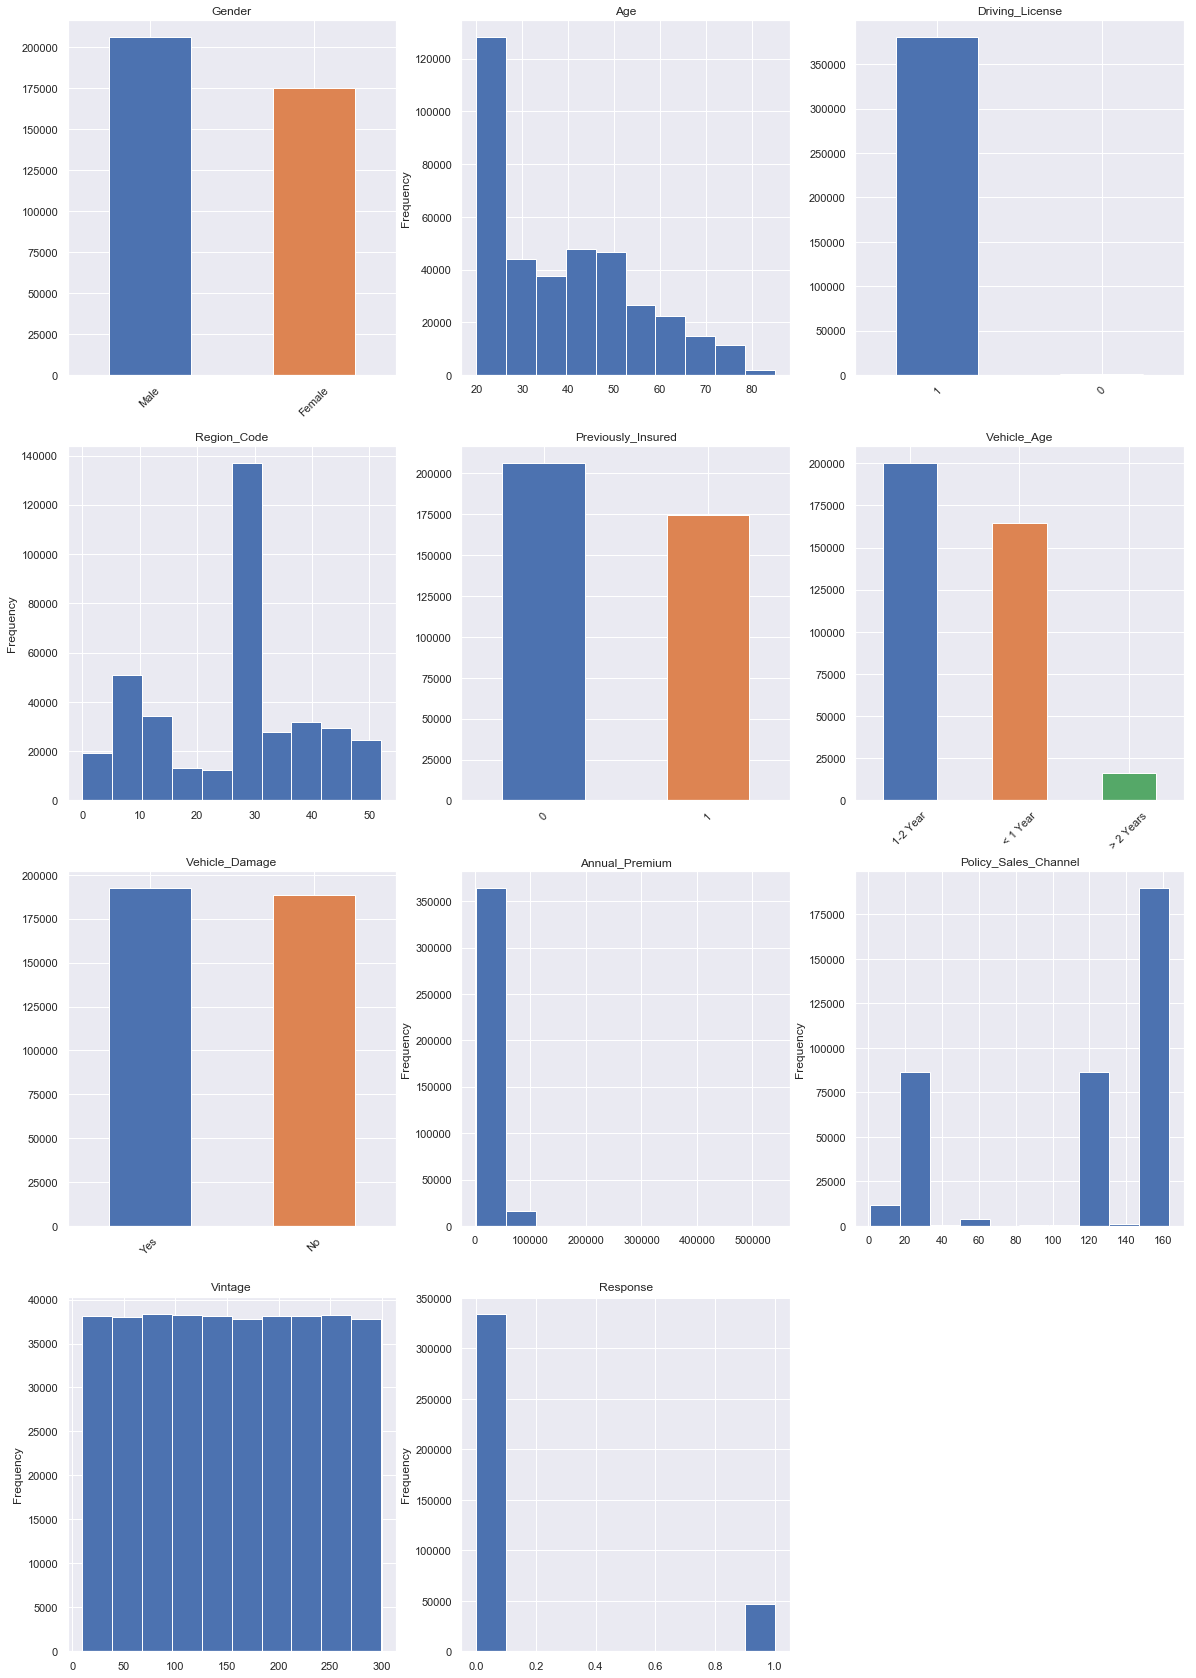

In [5]:
# Visualising distribution 

fig = plt.figure(figsize=(20,30))
axs = []

binary_col = [2,4]

for n in range(11):
    ax = fig.add_subplot(4, 3, n+1)
    col = sell_data_train.columns[n]
    if n in binary_col or sell_data_train[col].dtype == object:
        sell_data_train[col].value_counts(dropna=False).plot(
            kind='bar',
            ax=ax,
            title=sell_data_train.columns[n]
        )
        ax.tick_params(axis='x', rotation=45)
    else:
        sell_data_train[col].plot(kind='hist', ax=ax, title=sell_data_train.columns[n])

(0, 150000)

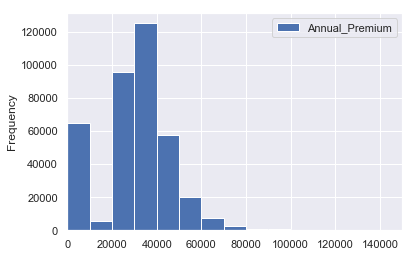

In [6]:
# Looking at 'Annual Premium' in more detail

ax = sell_data_train[['Annual_Premium']].plot(kind='hist', bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000])
ax.set_xlim(0,150000)

<b>Some observations / to-do </b><br>
- Need to <b>encode</b> 'Gender' (one-hot), 'Vehicle_Damage' (one-hot), 'Vehicle_Age' (ordinal)
- Need to <b>scale</b> 'Age', 'Region_Code, 'Policy_Sales_Channel', 'Vintage'
- 'Age', 'Region_Code', 'Policy_Sales_Channel' are <b>skewed</b>. Check dictionary for meaning of last two columns. Keep in mind for later.
- 'Driving_License' is '1' for all instances, so has no predictive value. Let's drop it. 
- There is significant <b>class imbalance in the target class</b>! The positive class (i.e. successful sale) is much less common. Will use imbalanced-learn library to implement upsampling using SMOTENC.

## Data preparation

In [7]:
# Setting X_train, y_train, X_val, y_val

y = np.array(sell_data_train[['Response']])
X = sell_data_train.drop('Response', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Column transformer drops license, transforms other cols

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

hot_ft = [0, 6]
ord_ft = [5]
drop_ft = [2]
scale_ft = [1, 3, 8, 9]

ct = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']]), ord_ft),
        ('one_hot', OneHotEncoder(), hot_ft),
        ('scale', MinMaxScaler(), scale_ft),
        ('to_drop', 'drop', drop_ft)
    ], remainder='passthrough')

In [8]:
y_train[:10]

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [9]:
X_train[:10]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
332804,Female,39,1,15.0,0,1-2 Year,Yes,52906.0,55.0,227
116249,Male,38,1,11.0,0,1-2 Year,Yes,23038.0,26.0,29
255006,Male,22,1,30.0,1,< 1 Year,No,45318.0,152.0,166
317475,Female,23,1,41.0,1,< 1 Year,No,29132.0,151.0,277
344213,Male,56,1,48.0,0,> 2 Years,Yes,2630.0,154.0,155
26230,Male,30,1,18.0,1,< 1 Year,No,35118.0,152.0,92
109100,Male,48,1,28.0,0,1-2 Year,Yes,50341.0,124.0,188
318078,Male,20,1,37.0,0,< 1 Year,Yes,47306.0,160.0,220
104642,Female,23,1,47.0,0,< 1 Year,No,2630.0,152.0,163


## Defining metrics
**Performance metrics recorded:** Recall, specificity, ROC AUC.
<br><br>**ROC AUC was used to select best estimators - why?**
- The overall goal here is two-fold: to recruit as many customers as possible, while not wasting resources on non-buyers.<br>
<br>
- Mathematically speaking, this translates into wanting high recall (many true positives) and low fall-out (low false positives). Unfortunately, there is usually a trade-off between the two, and a good model strikes the right balance between recall and fall-out.<br>
<br>
- **Based on this, I choose ROC AUC as my main metric, because it reflects both recall and fallout. By optimising the ROC AUC, I hope to find the right balance between identifying buyers and identifying non-buyers. This is based on the assumption that the opportunity cost of missing a potential buyer is equal to the cost of pursuing a non-buyer.**
<br>
<br>
- This assumption would not hold in many cases. To maximize profit, a better approach would have been to use a custom function that reflects the opportunity cost of missing a potential buyer as well as the cost of reaching out to a non-buyer. Unfortunately, these data were not available.<br>

In [10]:
# Importing metrics, cross_validate, GridSearchCV

from sklearn.metrics import roc_auc_score, recall_score, precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

metrics = ['roc_auc', 'recall', 'precision']

# Function to calculate averages from dictionary returned by cross_validate

def avg_scores(metrics_list, score_dict):
    """Average the metrics returned by sklearn.model_selection.cross_validate() across
    all folds.
    Args:
        metrics_list (list): List containing metrics passed to cross_validate().
        score_dict (dict): Dict returned by cross_calidate().
    Returns:
        avg_dict (dict): Dictionary containing the averaged metrics. 
    """
    avg_dict = {}
    for m in metrics_list:
        avg_dict[m] = np.mean(score_dict['test_{}'.format(m)])
    return avg_dict

# Function to extract best index, params, score from GridSearchCV results dictionary

def grid_best(metrics_list, gridcv_instance):
    best_dict = {}
    
    best_dict['best_index'] = gridcv_instance.best_index_
    best_dict['best_params'] = gridcv_instance.best_params_
    
    for m in metrics_list:
        best_dict[m] = gridcv_instance.cv_results_['mean_test_{}'.format(m)][gridcv_instance.best_index_]

    return best_dict

## Setting up pipeline 

Aside from the classifier, the pipieline will include the column transformer and the upsampling step.
<br><br>Upsampling will be implemented usign SMOTENC from imblearn.
<br><br>Because of this, I will use imblearn's own pipeline class. Unlike the sklearn pipeline class, imblearn ensures that the validation set is *not* oversampled. Oversampling in the validation set would distort error metrics.

In [11]:
# Defining function to generate pipeline with ColumnTransformer, SMOTENC, and a classifier.

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC

def make_pipe(clf):
    """Makes pipieline with desired classifier and pre-set transformers. 
    Args:
        clf (sklearn estimator): Desired classifier. Inclue desired parameters.
    Returns:
        pipe (imblearn.pipeline.Pipeline) 
    """  
    pipe = Pipeline(steps=[
        ('sampling', SMOTENC(categorical_features=ord_ft+hot_ft, random_state=42, n_jobs=-1)),
        ('transfomer', ct),
        ('clf', clf)
    ], memory='pipe_cache')

    return pipe

## Training and selecting models
### Logistic regression
#### Lasso regularisation
Due to the number of features, I will first try Lasso regression.

In [12]:
from sklearn.linear_model import SGDClassifier

# Training / evaluating model with cross-validation

log_model = make_pipe(SGDClassifier(loss='log', penalty='l1', random_state=42))
log_scores = cross_validate(log_model, X_train, y_train, scoring=metrics)

# Averaging across folds

log_avg_scores = avg_scores(metrics, log_scores)
print(log_avg_scores)

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\pipeline.py:240: UserWarning: Persisting input arguments took 2.42s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name]
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\pipeline.py:233: UserWarning: Persisting input arguments took 3.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example

{'roc_auc': 0.7886522697286023, 'recall': 0.6820530820458581, 'precision': 0.2540935249807958}


#### Hyperparameter tuning using GridSearchCV

**Performance is moderate, with a middling ROC AUC and recall and low precision.** At the moment, we are correctly identifying some of the real opportunities, but also wasting resources by going after the wrong customers.<br>

Next, I will examine different combinations of hyperparameters systematically using GridSearchCV:
- penalty, defines whether to use Lasso, Ridge or Elastic Net regularisation
- alpha, determines extent of regularisation
- l1_ratio (when using Elastic Net), defines the proportion of Lasso regularisation.

In [13]:
# Defining grid for search

log_param_grid = [
    {'clf__penalty': ['l1', 'l2'], 
    'clf__alpha': [1, 5, 10, 50, 100, 500, 1000]
    },
    {'clf__penalty': ['elasticnet'],
    'clf__l1_ratio': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
    'clf__alpha': [1, 5, 10, 50, 100, 500, 1000]
    }]

# Hyperparameter tuning using GridSearchCV

log_model = make_pipe(SGDClassifier(loss='log', random_state=42, max_iter=2000))

grid_search_log = GridSearchCV(log_model, log_param_grid, scoring=metrics, refit='roc_auc')
grid_search_log.fit(X_train, y_train)

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classifica

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classifica

GridSearchCV(estimator=Pipeline(memory='pipe_cache',
                                steps=[('sampling',
                                        SMOTENC(categorical_features=[5, 0, 6],
                                                random_state=42)),
                                       ('transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['< '
                                                                                                     '1 '
                                                                                                     'Year',
                                                                                                     '1-2 '
                                                                                                  

Let's obtain the best parameters, the best index, and the best ROC AUC.<br>
<br>
I will also obtain the best estimator and save it for future use.

In [14]:
# Saving best model refit on entire dataset for future use

from joblib import dump, load

best_estimator_log = grid_search_log.best_estimator_
dump(best_estimator_log, 'log_model.joblib')

['log_model.joblib']

In [17]:
# Extracting best index, params, score from GridSearchCV results dictionary

best_log = grid_best(metrics, grid_search_log)
print(best_log)

{'best_index': 14, 'best_params': {'clf__alpha': 1, 'clf__l1_ratio': 0.05, 'clf__penalty': 'elasticnet'}, 'best_roc_auc': 0.7659955733341425, 'recall': 0.18472230101138531, 'precision': 0.08389872485606445}


**ROC AUC is high, but recall is very low. It seems that logistic regression is not appropriate for this task.**

In [18]:
grid_search_log.cv_results_

{'mean_fit_time': array([ 18.89274907,  50.92494969,  10.99894795,  31.24767289,
         10.31096706,  24.54365168, 152.22352986,  13.28239136,
        185.61221781,  11.06084986, 184.48936162,   7.96784663,
        202.76330791,   7.40568261,  28.47711329,  26.77483768,
         26.17651324,  24.75664554,  24.25244627,  24.17600532,
         23.42437034,  19.02243443,  18.0186799 ,  14.94164519,
         16.36801481,  17.819663  ,  17.50348701,  18.49723344,
         18.25932307,  17.77642479,  16.01364183,  16.10059156,
         16.86558928,  15.9029408 ,  12.62273183,   9.8334599 ,
         15.55725427,  15.39909124,  14.97593384,  14.68715925,
         14.17565093,  14.23674321,  13.69637561,  12.91324906,
         12.107231  ,  11.07971859,   9.42477093,   9.38939157,
          9.4627943 ,   9.35660081,   9.4024961 ,   9.39774122,
          9.24407606,   9.05714145,   9.0324439 ,   8.69324069,
          6.49871449,   8.13595967,   8.35186591,   8.28937812,
          8.29027963,  

The 'mean_test_recall' array shows that many models have perfect recall (i.e. = 1), but low ROC AUC. These models simply predict most instances to be positive, which does not meet out goal of maximising sales while minimizing marketing expenditure. The SGDClassifier with the best parameters achieves by far the best balance.

### Linear SVC

#### Default parameters

This includes l2 regularization, which did not perform very well on its own in logistic regression. Nonetheless, it will be interesting to see how it compares to logistic regression.<br><br>
(N.B.: SVC with an RBF kernel might work very well for this dataset, but it has very high computational complexity, so I cannot implement it here.)

In [12]:
from sklearn.svm import LinearSVC

# Training / evaluating model with cross-validation

svc_model = make_pipe(LinearSVC(dual=False, random_state=42))
svc_scores = cross_validate(svc_model, X_train, y_train, scoring=metrics)

# Averaging across folds

svc_avg_scores = avg_scores(metrics, svc_scores)
print(svc_avg_scores)

{'roc_auc': 0.8277368914190231, 'recall': 0.9725442827937881, 'precision': 0.24890504045459508}


<b>ROC AUC is slightly higher than for logistic regression, but recall is much better. Let's see if a grid search can further improve this model. </b>

#### Hyperparameter tuning using GridSearchCV

In [14]:
# Defining grid for search

svc_param_grid = [
    {'clf__penalty': ['l1', 'l2'], 
    'clf__C': [0.1, 0.5, 1, 5, 10, 50, 100]
    }]

# Hyperparameter tuning using GridSearchCV
# SVC pipeline generated above with standard parameters will be re-used here

grid_search_svc = GridSearchCV(svc_model, svc_param_grid, scoring=metrics, refit='roc_auc')
grid_search_svc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(memory='pipe_cache',
                                steps=[('sampling',
                                        SMOTENC(categorical_features=[5, 0, 6],
                                                random_state=42)),
                                       ('transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['< '
                                                                                                     '1 '
                                                                                                     'Year',
                                                                                                     '1-2 '
                                                                                                  

In [17]:
# Saving best model refit on entire dataset for future use

from joblib import dump, load

best_estimator_svc = grid_search_svc.best_estimator_
dump(best_estimator_svc, 'svc_model.joblib')

# Extracting best index, params, score from GridSearchCV results dictionary

best_svc = grid_best(metrics, grid_search_svc)
print(best_svc)

{'best_index': 0, 'best_params': {'clf__C': 0.1, 'clf__penalty': 'l1'}, 'roc_auc': 0.8283952871105408, 'recall': 0.9725173793828905, 'precision': 0.24939707474390493}


In [18]:
grid_search_svc.cv_results_

{'mean_fit_time': array([8.52328486, 6.89263229, 6.68615327, 6.84703422, 6.68939648,
        6.87100487, 6.80707941, 7.01088901, 7.50183754, 7.0226501 ,
        6.76081295, 6.82229862, 6.65002308, 6.79928584]),
 'std_fit_time': array([0.26756122, 0.17988342, 0.03024132, 0.16293071, 0.12046756,
        0.18378783, 0.13061182, 0.22646135, 0.32467883, 0.18780072,
        0.09524762, 0.24159161, 0.04924767, 0.13639596]),
 'mean_score_time': array([0.15690923, 0.14277148, 0.14681926, 0.14264398, 0.1409658 ,
        0.14165149, 0.1443089 , 0.15933776, 0.14984584, 0.14430876,
        0.14410706, 0.14197297, 0.1405777 , 0.14217429]),
 'std_score_time': array([1.83921440e-02, 2.23570056e-03, 7.65687426e-03, 2.20305152e-03,
        8.26838143e-04, 1.98288064e-03, 6.04820953e-03, 1.53061574e-02,
        5.88745034e-03, 6.05188443e-03, 6.10618552e-03, 1.86151774e-03,
        1.71943274e-05, 2.06467406e-03]),
 'param_clf__C': masked_array(data=[0.1, 0.1, 0.5, 0.5, 1, 1, 5, 5, 10, 10, 50, 50, 100,
 

The best result obtained by grid search is marginally better than the default parameters. Indeed, analysis of the results show that performance does not vary much. This suggests that further hyperparameter tuning is not necessary.

### Random Forest classifier
#### Default parameters

This uses Gini impurity and 100 estimators. 

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = make_pipe(RandomForestClassifier(random_state=42))
rf_scores = cross_validate(rf_model, X_train, y_train, scoring=metrics)

# Averaging across folds

rf_avg_scores = avg_scores(metrics, rf_scores)
print(rf_avg_scores)

{'roc_auc': 0.8321887476060619, 'recall': 0.4661038246049463, 'precision': 0.31957850277655797}


#### Hyperparameter tuning using GridSearchCV

In [20]:
# Defining grid for search

rf_param_grid = [
    {'clf__n_estimators':[4, 8, 16, 32, 64, 100, 200],
     'clf__max_depth': [2, 4, 8, 16, 32, 64, 100]
    },
    {'clf__n_estimators':[4, 8, 16, 32, 64, 100, 200],
     'clf__min_samples_split':[0.01, 0.025, 0.05, 0.1, 0.25]
    }]

# Hyperparameter tuning using GridSearchCV
# SVC pipeline generated above with standard parameters will be re-used here

grid_search_rf = GridSearchCV(rf_model, rf_param_grid, scoring=metrics, refit='roc_auc')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(memory='pipe_cache',
                                steps=[('sampling',
                                        SMOTENC(categorical_features=[5, 0, 6],
                                                random_state=42)),
                                       ('transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['< '
                                                                                                     '1 '
                                                                                                     'Year',
                                                                                                     '1-2 '
                                                                                                  

In [21]:
# Saving best model refit on entire dataset for future use

from joblib import dump, load

best_estimator_rf = grid_search_rf.best_estimator_
dump(best_estimator_rf, 'rf_model.joblib')

# Extracting best index, params, score from GridSearchCV results dictionary

best_rf = grid_best(metrics, grid_search_rf)
print(best_rf)

{'best_index': 27, 'best_params': {'clf__max_depth': 16, 'clf__n_estimators': 200}, 'roc_auc': 0.8402495230017726, 'recall': 0.7158418679622823, 'precision': 0.31207635854509463}


In [22]:
grid_search_rf.cv_results_

{'mean_fit_time': array([  6.61236806,   7.1067606 ,   7.95932503,  10.3347465 ,
         14.85470262,  24.43166733,  36.89951301,   6.59105921,
          8.56616054,  10.16444883,  14.39837532,  21.42349958,
         31.52388539,  55.63087258,   7.54838452,   9.48755913,
         12.67151051,  19.68660774,  33.3028224 ,  48.48902268,
         90.03273501,   8.18177419,  10.0528533 ,  14.54862022,
         25.10479016,  40.94145541,  61.8542006 , 116.37637892,
          8.30121894,  11.11618366,  16.8773715 ,  28.25598912,
         51.06310005,  76.99628062, 148.60028934,   8.36372013,
         11.33802705,  17.21798444,  28.86841035,  52.34427123,
         80.41592822, 154.63163214,   8.41127067,  11.59735565,
         17.72093425,  29.02623949,  52.66913013,  78.86501279,
        160.63486385,   7.70631533,   9.59781609,  14.14364762,
         21.89829521,  38.04131203,  56.15465326, 107.09010859,
          7.50453887,   9.10729508,  12.98767028,  19.9772191 ,
         34.64206228,  

This represents a good improvement over the random parameters. I will proceed with a finer grid search focussing on a narrower range of the max_depth and n_estimarors.

#### Finer grid search

In [15]:
# Defining grid for search

rf_param_grid = [
    {'clf__n_estimators' : [200],
     'clf__max_depth' : np.arange(8,26,2)
    }]

# Hyperparameter tuning using GridSearchCV
# SVC pipeline generated above with standard parameters will be re-used here

grid_search_rf = GridSearchCV(rf_model, rf_param_grid, scoring=metrics, refit='roc_auc')
grid_search_rf.fit(X_train, y_train)

# Saving best model refit on entire dataset for future use

from joblib import dump, load

best_estimator_rf = grid_search_rf.best_estimator_
dump(best_estimator_rf, 'rf_model.joblib')

# Extracting best index, params, score from GridSearchCV results dictionary

best_rf = grid_best(metrics, grid_search_rf)
print(best_rf)

{'best_index': 4, 'best_params': {'clf__max_depth': 16, 'clf__n_estimators': 200}, 'roc_auc': 0.8402495230017726, 'recall': 0.7158418679622823, 'precision': 0.31207635854509463}


The finer grid search results in the same hyperparameters as the initial search. It is likely that increasing the number of predictors would improve performance. Unfortunately, this isn't feasible due to the computational complexity.

### Extra trees classifier

The extra trees classifier introduces a bit more variability by used random thresholds while growing trees. It can often perform better than random forest classifiers. Additionally, it is signficantly faster to train, so that the number of trees can be increased quite a bit.

In [12]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_model = make_pipe(ExtraTreesClassifier(random_state=42))

In [13]:
# Defining grid for search

extra_trees_param_grid = [
    {'clf__n_estimators':[4, 8, 16, 32, 64, 128, 256, 512, 1024],
     'clf__max_depth': [2, 4, 8, 16, 32]
    },
    {'clf__n_estimators':[4, 8, 16, 32, 64, 128, 256, 512, 1024],
     'clf__min_samples_split':[0.01, 0.025, 0.05, 0.1, 0.25]
    }]

# Hyperparameter tuning using GridSearchCV
# SVC pipeline generated above with standard parameters will be re-used here

grid_search_extra_trees = GridSearchCV(extra_trees_model, extra_trees_param_grid, scoring=metrics, refit='roc_auc')
grid_search_extra_trees.fit(X_train, y_train)

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while sel

C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\cristobal.marrerowin\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while sel

GridSearchCV(estimator=Pipeline(memory='pipe_cache',
                                steps=[('sampling',
                                        SMOTENC(categorical_features=[5, 0, 6],
                                                random_state=42)),
                                       ('transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['< '
                                                                                                     '1 '
                                                                                                     'Year',
                                                                                                     '1-2 '
                                                                                                  

In [14]:
# Saving best model refit on entire dataset for future use

from joblib import dump, load

best_estimator_extra_trees = grid_search_extra_trees.best_estimator_
dump(best_estimator_extra_trees, 'extra_trees_model.joblib')

# Extracting best index, params, score from GridSearchCV results dictionary

best_extra_trees = grid_best(metrics, grid_search_extra_trees)
print(best_extra_trees)

{'best_index': 35, 'best_params': {'clf__max_depth': 16, 'clf__n_estimators': 1024}, 'roc_auc': 0.8393546080171687, 'recall': 0.823513946296511, 'precision': 0.2972157965554087}


It looks like the Extra Trees classifier performs about the same as the Random Forest regressor.

### KNN classifier

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = make_pipe(KNeighborsClassifier())

In [25]:
# Defining grid for search

knn_param_grid = [
    {'clf__n_neighbors':[2, 4, 8, 16],
    'clf__weights':['uniform', 'distance'],
     'clf__p':[1, 2]
    }]

# Hyperparameter tuning using GridSearchCV
# SVC pipeline generated above with standard parameters will be re-used here

grid_search_knn = GridSearchCV(knn_model, knn_param_grid, scoring=metrics, refit='roc_auc')
grid_search_knn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(memory='pipe_cache',
                                steps=[('sampling',
                                        SMOTENC(categorical_features=[5, 0, 6],
                                                random_state=42)),
                                       ('transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['< '
                                                                                                     '1 '
                                                                                                     'Year',
                                                                                                     '1-2 '
                                                                                                  

In [26]:
# Saving best model refit on entire dataset for future use

from joblib import dump, load

best_estimator_knn = grid_search_knn.best_estimator_
dump(best_estimator_knn, 'knn_model.joblib')

# Extracting best index, params, score from GridSearchCV results dictionary

best_knn = grid_best(metrics, grid_search_knn)
print(best_knn)

{'best_index': 13, 'best_params': {'clf__n_neighbors': 16, 'clf__p': 1, 'clf__weights': 'distance'}, 'roc_auc': 0.7820876685691536, 'recall': 0.7798154710195742, 'precision': 0.2435466501876966}


### Naive Bayes classifier

In [27]:
from sklearn.naive_bayes import GaussianNB

# Defining, cross-validating model

nb_model = make_pipe(GaussianNB())
nb_scores = cross_validate(nb_model, X_train, y_train, scoring=metrics)

In [28]:
# Averaging across folds

nb_avg_scores = avg_scores(metrics, nb_scores)
print(nb_avg_scores)

{'roc_auc': 0.8126037580982018, 'recall': 0.9783257827704859, 'precision': 0.24156557326077682}


In [29]:
# Saving model after refitting on entire dataset

nb_model_re = make_pipe(GaussianNB())
nb_model_re.fit(X_train, y_train)

from joblib import dump, load

dump(nb_model_re, 'nb_model.joblib')

['nb_model.joblib']

## Prediction for Kaggle submission

### Loading, transforming test data

In [ ]:
# # Loading test data

# sell_data_test = pd.read_csv('train.csv', index_col='id')

# # Double-checking test data

# sell_data_test.head()

# # Transforming test data

# X_test = ct.transform(sell_data_test)

In [ ]:
# # Predictions using log_estimator

# from sklearn.linear_model import SGDClassifier
# from joblib import dump, load

# best_estimator_log = load('log_model.joblib')
# log_pred = best_estimator_log.predict(X_test)

# log_pred.head()